In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from transformers import LogTransformer, SquareRootTransformer, ZScoreTrimmer, UpperBoundTrimmer, LowerBoundTrimmer, FillNaColumnTransformer, KNNColumnImputer, OneHotColumnEncoder, OrdinalColumnEncoder, ColumnDropper, StandardColumnScaler, ClusterSimilarity
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [2]:
df = pd.read_csv("data/belgian_property_prices.csv")

In [3]:
df = df.dropna(subset=["lat"])

In [4]:
df["price_norm"] = np.log(df.price)

In [5]:
features_to_drop = ["price_norm", "external_reference", "latest_land_use_designation", "website", "reference_number_of_the_epc_report", "street", "housenumber", "city", "postal", "state", "heating_type",
    "surroundings_type", "kitchen_type"]

In [6]:
numerical_features = [
    "bathrooms",
    "bedroom_1_surface",
    "bedroom_2_surface",
    "bedroom_3_surface",
    "bedrooms",
    "co2_emission",
    "cadastral_income",
    "construction_year",
    "covered_parking_spaces",
    "garden_surface",
    "kitchen_surface",
    "living_area",
    "living_room_surface",
    "outdoor_parking_spaces",
    "primary_energy_consumption",
    "street_frontage_width",
    "surface_of_the_plot",
    "toilets",
    "width_of_the_lot_on_the_street",
    "yearly_theoretical_total_energy_consumption",
    "lat",
    "lng"
    ]

In [7]:
categorical_features = [
    "as_built_plan",
    "basement",
    "connection_to_sewer_network",
    "dining_room",
    "double_glazing",
    "flood_zone_type",
    "furnished",
    "gas_water__electricity",
    "office",
    "planning_permission_obtained",
    "possible_priority_purchase_right",
    "proceedings_for_breach_of_planning_regulations",
    "subdivision_permit",
    "tv_cable",
    "tenement_building",
    "available_as_of",
    "building_condition",
    "number_of_frontages",
    "energy_class",
    "planning_permission_obtained", 
    ]

In [8]:
number_of_clusters = 8
cluster_simil = ClusterSimilarity(columns=["lat", "lng"], n_clusters=number_of_clusters, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(df, sample_weight=df.price)

for i in range(1,number_of_clusters+1):
    feature_name = f"Cluster_{i}_similarity"
    df[feature_name] = similarities[:,i-1]
    numerical_features.append(feature_name)

c:\Repositories\OpenUniversiteit\BelgianHousingPrices\house-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


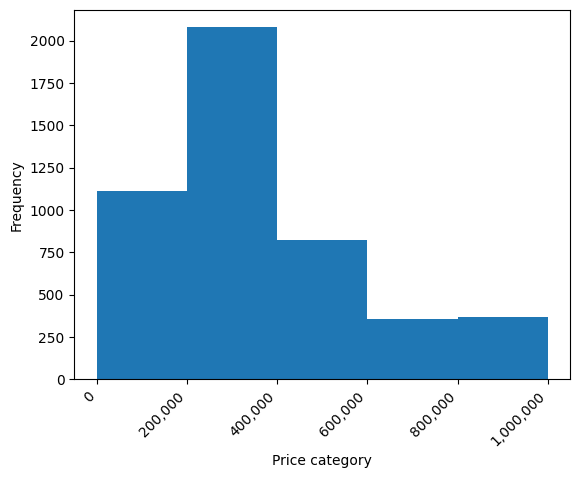

In [9]:
df["price_cat"] = pd.cut(df.price, bins=[0,250000,500000,750000,1000000,np.inf], labels=[0,250000,500000,750000,1000000])
train_set, test_set = train_test_split(df, test_size=0.2, stratify=df.price_cat, random_state=42)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Frequency")
plt.xlabel("Price category")
plt.hist(df.price_cat, bins=5)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
plt.show()
for set_ in (train_set, test_set):
    set_.drop("price_cat", axis=1, inplace=True)

In [10]:
pipeline = Pipeline([
    ("column_dropping", ColumnDropper(columns=features_to_drop)),
    ("log_transforms", LogTransformer(columns=[
        "co2_emission",
        "cadastral_income",
        "garden_surface",
        "kitchen_surface",
        "living_area",
        "living_room_surface",
        "street_frontage_width",
        "surface_of_the_plot",
        "width_of_the_lot_on_the_street", 
        "price"
    ])),
    ("square_root_transforms", SquareRootTransformer(columns=[
        "bathrooms",
        "bedroom_1_surface",
        "primary_energy_consumption",
        "yearly_theoretical_total_energy_consumption"
    ])),
    ("zscore_trimming", ZScoreTrimmer(columns=[
        "living_room_surface",
        "primary_energy_consumption",
        "yearly_theoretical_total_energy_consumption"
    ])),                                           
    ("upperbound_trimming", UpperBoundTrimmer(column_boundaries={
        "bathrooms": 3,
        "bedroom_1_surface":8,
        "bedroom_2_surface":40,
        "bedroom_3_surface":40,
        "bedrooms":10,
        "co2_emission": 10,
        "covered_parking_spaces": 10,
        "garden_surface":11,
        "kitchen_surface":4,
        "outdoor_parking_spaces":20,
        "street_frontage_width": 4,
        "toilets":10,
        "width_of_the_lot_on_the_street":5,
        "number_of_frontages":4
    })),
     ("lowerbound_trimming", LowerBoundTrimmer(column_boundaries={
        "co2_emission":0,
        "cadastral_income":4,
        "garden_surface":0,
        "kitchen_surface":1,
        "living_area":3,
        "street_frontage_width":0,
        "surface_of_the_plot":0,
        "width_of_the_lot_on_the_street": 0,
        "number_of_frontages":1,
        "price": 11
     })), 
    ('filling na', FillNaColumnTransformer(fill_value='Missing', columns=[
        "available_as_of",
        "building_condition",
        "energy_class", 
    ])),
    ('filling na2', FillNaColumnTransformer(fill_value=0, columns=categorical_features)),     
     ("one_hot_encoding", OneHotColumnEncoder(columns=[
        "available_as_of",
        "building_condition",
        "number_of_frontages",
    ])),
    ("ordinal_encoding", OrdinalColumnEncoder(columns=[
        "energy_class",
        ])),
    ("KNN_imputing", KNNColumnImputer(n_neighbors=5,columns=numerical_features)),
    ("standard_scaling", StandardColumnScaler(columns=numerical_features))
])

In [11]:

prepared_train_set = data=pipeline.fit_transform(train_set)

c:\Repositories\OpenUniversiteit\BelgianHousingPrices\house-env\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


ZScoreTrimmer - Trimmed a total of 3 columns and removed 18 outliers.
UpperBoundTrimmer - Column bathrooms: 9 outliers removed. Max value of 3.605551275463989 reduced to 3.0.
UpperBoundTrimmer - Column bedroom_1_surface: 4 outliers removed. Max value of 13.0 reduced to 7.745966692414834.
UpperBoundTrimmer - Column bedroom_2_surface: 8 outliers removed. Max value of 1350.0 reduced to 39.0.
UpperBoundTrimmer - Column bedroom_3_surface: 14 outliers removed. Max value of 1818.0 reduced to 40.0.
UpperBoundTrimmer - Column bedrooms: 12 outliers removed. Max value of 20.0 reduced to 10.0.
UpperBoundTrimmer - Column co2_emission: 1 outliers removed. Max value of 10.943004258145342 reduced to 9.828386780026877.
UpperBoundTrimmer - Column covered_parking_spaces: 9 outliers removed. Max value of 80.0 reduced to 10.0.
UpperBoundTrimmer - Column garden_surface: 1 outliers removed. Max value of 11.37366339763672 reduced to 10.404262840448617.
UpperBoundTrimmer - Column kitchen_surface: 5 outliers re

In [12]:
random_forest = RandomForestRegressor(random_state=42, n_estimators=850, min_samples_split=4, min_samples_leaf=2, max_depth=45)

In [13]:
y_columns = ["price"]
X_columns =list(prepared_train_set.columns)
X_columns.remove("price")

In [14]:
random_forest.fit(prepared_train_set[X_columns], np.ravel(prepared_train_set[y_columns]))

RandomForestRegressor(max_depth=45, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=850, random_state=42)

Text(0.5, 1.0, 'Global Feature Importance')

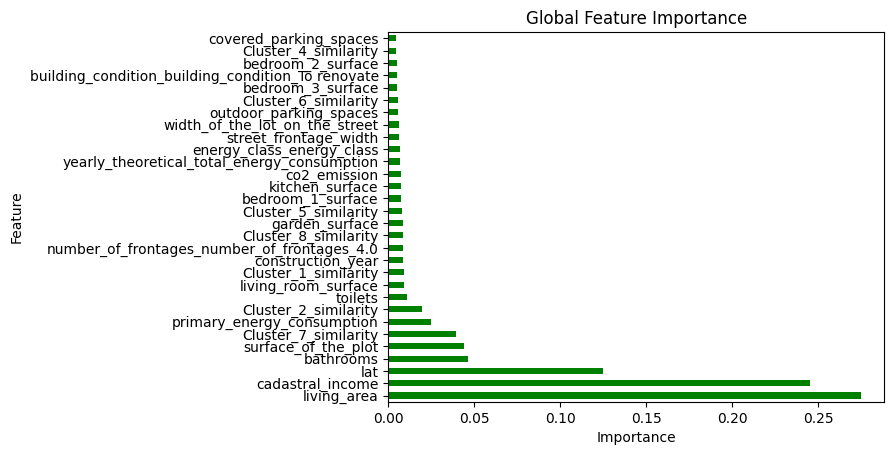

In [15]:
global_importances = pd.Series(random_forest.feature_importances_, index=X_columns)
global_importances.sort_values(ascending=False, inplace=True)
global_importances = global_importances.head(30)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance")

In [16]:
prepared_test_set = data=pipeline.fit_transform(test_set)

ZScoreTrimmer - Trimmed a total of 3 columns and removed 5 outliers.
UpperBoundTrimmer - Column bathrooms: 2 outliers removed. Max value of 3.605551275463989 reduced to 3.0.
UpperBoundTrimmer - Column bedroom_1_surface: 1 outliers removed. Max value of 38.62641583165593 reduced to 7.874007874011811.
UpperBoundTrimmer - Column bedroom_2_surface: 2 outliers removed. Max value of 60.0 reduced to 36.0.
UpperBoundTrimmer - Column bedroom_3_surface: 5 outliers removed. Max value of 1616.0 reduced to 40.0.
UpperBoundTrimmer - Column bedrooms: 4 outliers removed. Max value of 14.0 reduced to 9.0.
UpperBoundTrimmer - Column co2_emission: 0 outliers removed. Max value of 9.21024036697585 reduced to 9.21024036697585.
UpperBoundTrimmer - Column covered_parking_spaces: 0 outliers removed. Max value of 10.0 reduced to 10.0.
UpperBoundTrimmer - Column garden_surface: 0 outliers removed. Max value of 8.978660489639687 reduced to 8.978660489639687.
UpperBoundTrimmer - Column kitchen_surface: 2 outliers

In [17]:
from sklearn.metrics import mean_squared_error
y_columns = ["price"]
X_columns =list(prepared_test_set.columns)
X_columns.remove("price")
final_predictions = np.exp(random_forest.predict(prepared_test_set[X_columns]))
test = np.exp(prepared_test_set[y_columns])

final_rmse = mean_squared_error(test, final_predictions, squared=False)
print(final_rmse) 

233123.87341874366


In [18]:
test["predictions"] = final_predictions

In [19]:
test["error"] = np.abs(test["predictions"] - test["price"])

C:\Users\joachim.verschelde\AppData\Local\Temp\ipykernel_38888\2490405551.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_rmse_by_price = test.groupby('price_interval')['error'].mean().reset_index()
C:\Users\joachim.verschelde\AppData\Local\Temp\ipykernel_38888\2490405551.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='price_interval', y='error', data=mean_rmse_by_price, ci=None)  #


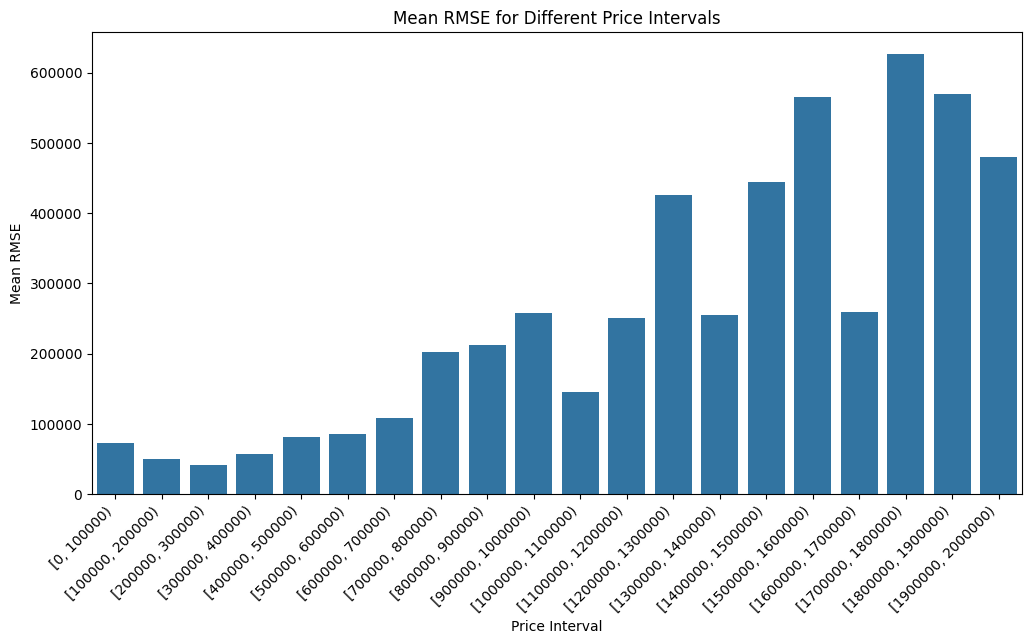

In [25]:
test['price_interval'] = pd.cut(test['price'], bins=np.arange(0, 2000001, 100000), right=False)

mean_rmse_by_price = test.groupby('price_interval')['error'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='price_interval', y='error', data=mean_rmse_by_price, ci=None)  #
plt.xlabel('Price Interval')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE for Different Price Intervals')
plt.xticks(rotation=45, ha='right') 
plt.show()

C:\Users\joachim.verschelde\AppData\Local\Temp\ipykernel_38888\3397414841.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_rmse_by_price = test.groupby('price_interval')['error_relative'].mean().reset_index()
C:\Users\joachim.verschelde\AppData\Local\Temp\ipykernel_38888\3397414841.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='price_interval', y='error_relative', data=mean_rmse_by_price, ci=None)  #


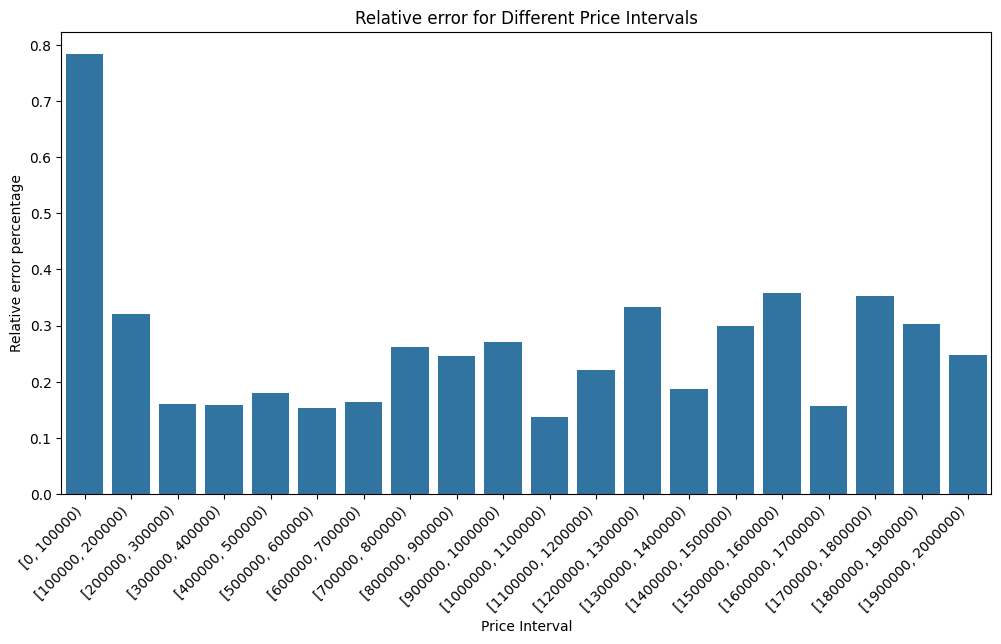

In [26]:
test['error_relative'] = test.error / test.price
test['price_interval'] = pd.cut(test['price'], bins=np.arange(0, 2000001, 100000), right=False)

mean_rmse_by_price = test.groupby('price_interval')['error_relative'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='price_interval', y='error_relative', data=mean_rmse_by_price, ci=None)  #
plt.xlabel('Price Interval')
plt.ylabel('Relative error percentage')
plt.title('Relative error for Different Price Intervals')
plt.xticks(rotation=45, ha='right') 
plt.show()

In [30]:
test["error_relative"].mean()

0.20872654198305882